#Subword Tokenization with the IMDB Reviews Dataset

##Download the IMDB reviews
- plain text
- subwords8k

In [9]:
import tensorflow_datasets as tfds

#Downloading plain_text default config
imdb_plaintext, info_plaintext = tfds.load("imdb_reviews", with_info = True, as_supervised = True)

#Doanloading subword encoded pretokenized dataset
imdb_subwords, info_subwords = tfds.load("imdb_reviews/subwords8k", with_info = True, as_supervised = True)

##Subword Text Encoding

We first see the process with plaintext.

In [8]:
# Get the train set
train_data = imdb_plaintext['train']
# Initialize sentences list
training_sentences = []
# Loop over all training examples and save to the list
for s,_ in train_data:
  training_sentences.append(s.numpy().decode('utf8'))

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
oov_tok = '<OOV>'

#Initialize the Tokenizer class
tokenizer_plaintext = Tokenizer(num_words = 10000, oov_token = oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer_plaintext.fit_on_texts(training_sentences)

# Generate the training sequences
sequences = tokenizer_plaintext.texts_to_sequences(training_sentences)

- If we use this, there will be lots of OOV tokens when decoding using the lookup dictionary it created.




In [11]:
sample_string = 'Tensorflow, from basics to mastery'

tokenized_string = tokenizer_plaintext.texts_to_sequences([sample_string])
original_string = tokenizer_plaintext.sequences_to_texts(tokenized_string)

print('Tokenized string is {}'.format(tokenized_string))
print('The original string is {}'.format(original_string))

Tokenized string is [[1, 37, 1, 6, 1]]
The original string is ['<OOV> from <OOV> to <OOV>']


Output:

``Tokenized string is [[1, 37, 1, 6, 1]]``

``The original string: ['<OOV> from <OOV> to <OOV>']``

- Increasing the `vocab_size` will just bloat the model.

**Subword text encoding** gets around this problem by using parts of the word to compose whole words. We can see the process of using subword text encoding by starting with the `encoder` object.

In [12]:
tokenizer_subwords = info_subwords.features['text'].encoder

In [13]:
tokenized_string = tokenizer_subwords.encode(sample_string)
original_string = tokenizer_subwords.decode(tokenized_string)

print ('Tokenized string is {}'.format(tokenized_string))
print ('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 2934, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: Tensorflow, from basics to mastery


Output:

``Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]``

``The original string: TensorFlow, from basics to mastery``

As you may notice, the sentence is correctly decoded. The downside is the token sequence is much longer. Instead of only 5 when using word-encoding, you ended up with 11 tokens instead. The mapping for this sentence is shown below:

In [14]:
# Show token to subword mapping:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_subwords.decode([ts])))

6307 ----> Ten
2327 ----> sor
2934 ----> flow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


##Training the model

You will now train your model using this pre-tokenized dataset. Since these are already saved as sequences, you can jump straight to making uniform sized arrays for the train and test sets. These are also saved as `tf.data.Dataset` type so you can use the padded_batch() method to create batches and pad the arrays into a uniform size for training.

In [15]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

# Get the train and test splits
train_data, test_data = imdb_subwords['train'], imdb_subwords['test'],

#Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

#Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = train_data.padded_batch(BATCH_SIZE)

We then build the model.

In [16]:
import tensorflow as tf

# Define dimensionality of the embedding
embedding_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer_subwords.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [17]:
num_epochs = 10

# Set the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Start training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 10s 23ms/step - loss: 0.6777 - accuracy: 0.6270 - val_loss: 0.6368 - val_accuracy: 0.7738
Epoch 2/10
391/391 [==============================] - 8s 20ms/step - loss: 0.5566 - accuracy: 0.7862 - val_loss: 0.4693 - val_accuracy: 0.8400
Epoch 3/10
391/391 [==============================] - 7s 19ms/step - loss: 0.4133 - accuracy: 0.8560 - val_loss: 0.3582 - val_accuracy: 0.8814
Epoch 4/10
391/391 [==============================] - 7s 19ms/step - loss: 0.3337 - accuracy: 0.8827 - val_loss: 0.2983 - val_accuracy: 0.8982
Epoch 5/10
391/391 [==============================] - 8s 20ms/step - loss: 0.2847 - accuracy: 0.8991 - val_loss: 0.2625 - val_accuracy: 0.9107
Epoch 6/10
391/391 [==============================] - 9s 22ms/step - loss: 0.2563 - accuracy: 0.9101 - val_loss: 0.2365 - val_accuracy: 0.9183
Epoch 7/10
391/391 [==============================] - 8s 21ms/step - loss: 0.2348 - accuracy: 0.9150 - val_loss: 0.2169 - val_accuracy: 0.927

##Visualizing the results

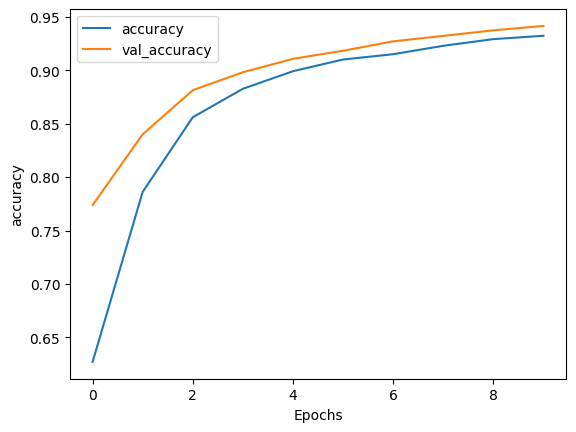

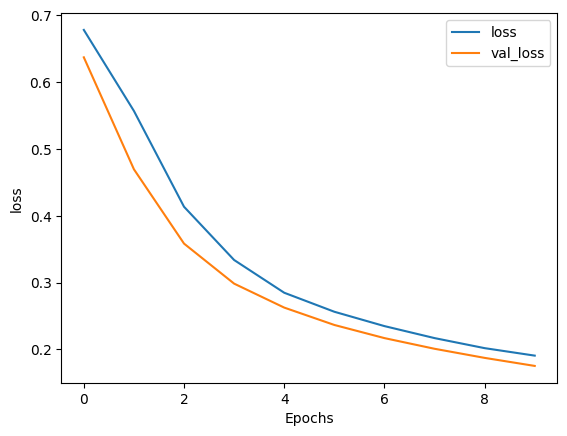

In [18]:
import matplotlib.pyplot as plt

#plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

#plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")